In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from tqdm import tqdm
import folium
import random
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from src import load_data as ld
from src import utils
from src import feature_exploring as fexp
from src import map_plot as mp
from src import ml_utils as mlu

# Some testing code

In [2]:
# How to read a npz file

In [3]:
data = np.load('data/training_data/alex_crowd_sourced_Drifting_longlines.measures.labels.npz')

In [4]:
df = pd.DataFrame(data.get("x"))
df.head(2)

,measure_coursestddev_43200,measure_speedavg_86400,measure_coursestddev_1800_log,measure_coursestddev_10800_log,measure_courseavg_43200,measure_cos_course,measure_daylightavg_1800,measure_coursestddev_21600,measure_speedstddev_1800,measure_distance_from_port,...,measure_daylight,measure_coursestddev_1800,measure_pos_21600,measure_coursestddev_3600_log,measure_speedavg_1800,measure_lonavg_43200,measure_speedstddev_1800_log,measure_courseavg_21600,measure_coursestddev_10800,measure_speed
0,0.405208,0.795068,-3.0,-0.726021,0.476011,0.570607,0.0,0.270995,8.171219e-07,1.0,...,0.0,0.0,0.014033,-3.0,0.817647,178.656452,-2.999645,0.448175,0.186923,0.817647
1,0.407976,0.795294,-3.0,-0.699922,0.466625,0.570607,0.0,0.277235,5.777924e-07,1.0,...,0.0,0.0,0.015865,-3.0,0.817647,178.656779,-2.999749,0.438519,0.198562,0.817647


In [5]:
data_2 = np.load('data/training_data/false_positives_Drifting_longlines.measures.labels.npz')

In [6]:
df_2 = pd.DataFrame(data_2.get("x"))

In [7]:
df_append = df.append(df_2)

In [8]:
df.shape[0]+df_2.shape[0]==df_append.shape[0]

True

# Some utils to load data

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> Data is distributed over a lot of files. Many of them, belong to a single gear type but are spread on different files.

I want some functions aimed to help loading data. Let's build a **load data code**.
</div>



In [2]:
path = 'data/training_data/' # all the data is here
listdir(path)

['alex_crowd_sourced_Drifting_longlines.measures.labels.npz',
 'alex_crowd_sourced_Purse_seines.measures.labels.npz',
 'alex_crowd_sourced_Unknown.measures.labels.npz',
 'false_positives_Drifting_longlines.measures.labels.npz',
 'false_positives_Fixed_gear.measures.labels.npz',
 'false_positives_Purse_seines.measures.labels.npz',
 'false_positives_Trawlers.measures.labels.npz',
 'false_positives_Unknown.measures.labels.npz',
 'kristina_longliner_Drifting_longlines.measures.labels.npz',
 'kristina_longliner_Fixed_gear.measures.labels.npz',
 'kristina_longliner_Unknown.measures.labels.npz',
 'kristina_ps_Purse_seines.measures.labels.npz',
 'kristina_ps_Unknown.measures.labels.npz',
 'kristina_trawl_Trawlers.measures.labels.npz',
 'pybossa_project_3_Drifting_longlines.measures.labels.npz',
 'pybossa_project_3_Fixed_gear.measures.labels.npz',
 'pybossa_project_3_Pole_and_line.measures.labels.npz',
 'pybossa_project_3_Purse_seines.measures.labels.npz',
 'pybossa_project_3_Trawlers.measures.

The data is distributed on different npz files and classified by source and gear type.

In [2]:
gear_type_list = ['Drifting_longlines', 'Fixed_gear','Purse_seines','Trawlers','Trollers','Pole_and_line','Unknown']

In [3]:
# loading all dataframes
drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df = ld.load_multiple(gear_type_list)

In [4]:
dfs = [drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df]

# EDA

### Feature to predict: is_fishing

In [14]:
# shapes
drifting_df.shape, fixed_gear_df.shape, purse_df.shape, trawlers_df.shape, trollers_df.shape, pole_df.shape, unknown_df.shape

((778960, 81),
 (131820, 81),
 (186906, 81),
 (565502, 81),
 (22552, 81),
 (14170, 81),
 (297190, 81))

In [15]:
# exploring the is_fishing column (feature to predict)

In [5]:
def get_is_fishing_values(df):
    '''
    simple function to check the is_fishing column
    '''
    return df.is_fishing.unique()

In [6]:
# not binary label
get_is_fishing_values(drifting_df)

array([1.        , 0.        , 0.33333334, 0.66666669, 0.25      ,
       0.75      ])

In [7]:
# not binary label in every dataframe
list(map(get_is_fishing_values,[drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df]))

[array([1.        , 0.        , 0.33333334, 0.66666669, 0.25      ,
        0.75      ]),
 array([0.        , 1.        , 0.66666669, 0.33333334, 0.25      ,
        0.80000001, 0.75      , 0.60000002, 0.40000001]),
 array([0.        , 1.        , 0.66666669, 0.33333334, 0.25      ,
        0.75      , 0.80000001]),
 array([0.        , 1.        , 0.66666669, 0.33333334, 0.75      ,
        0.25      , 0.80000001]),
 array([1.        , 0.        , 0.66666669, 0.33333334]),
 array([0.        , 0.33333334, 0.75      , 0.66666669, 0.25      ,
        1.        , 0.40000001, 0.16666667]),
 array([0.        , 1.        , 0.66666669, 0.33333334, 0.25      ,
        0.75      , 0.2       , 0.60000002, 0.80000001])]

The is_fishing label is the mean of the predict from many sources, this is why is a value between 0 and 1.

Set a threshold to make the is_fishing column a binary column [0,1] is needed 

In [8]:
# we will set a threshold on 0.5

In [9]:
def set_threshold(df,threshold):
    '''
    convert the is_fishing column into binary labeled column depending on the threshold passed as argument
    '''
    df['is_fishing'] = np.where(df.is_fishing > threshold,1,0)

In [10]:
set_threshold(drifting_df,0.5)

In [11]:
get_is_fishing_values(drifting_df)

array([1, 0])

In [12]:
# applying 'set_threshold' to all the df's

In [13]:
for df in dfs:
    set_threshold(df,0.5)

In [14]:
# repiting the code above
list(map(get_is_fishing_values,[drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df]))

[array([1, 0]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([1, 0]),
 array([0, 1]),
 array([0, 1])]

#### How is the data distributed

In [26]:
drifting_df.columns

Index(['measure_coursestddev_43200', 'measure_speedavg_86400',
       'measure_coursestddev_1800_log', 'measure_coursestddev_10800_log',
       'measure_courseavg_43200', 'measure_cos_course',
       'measure_daylightavg_1800', 'measure_coursestddev_21600',
       'measure_speedstddev_1800', 'measure_distance_from_port',
       'measure_count_1800', 'course', 'measure_sin_course',
       'measure_speedstddev_10800', 'measure_speedavg_21600', 'speed',
       'is_fishing', 'measure_pos_86400', 'measure_daylightavg_43200',
       'measure_latavg_86400', 'measure_latavg_10800', 'distance_from_port',
       'measure_latavg_1800', 'measure_pos_1800', 'measure_lonavg_3600',
       'measure_count_3600', 'lon', 'measure_speedavg_10800',
       'measure_latavg_3600', 'measure_coursestddev_43200_log',
       'measure_latavg_21600', 'measure_daylightavg_10800',
       'measure_count_86400', 'measure_count_21600',
       'measure_speedstddev_86400_log', 'measure_lonavg_1800',
       'measure_course

In [27]:
# checking the values of random cols
df = drifting_df[["measure_coursestddev_43200", "speed", "course", "measure_distance_from_port"]].sample(20000)

In [28]:
df.speed.sort_values(ascending=False).head(10)

123650    97.300003
123627    77.900002
123624    64.900002
37134     59.799999
35556     52.200001
123697    36.700001
123596    33.000000
21045     15.100000
26328     14.900000
26244     14.800000
Name: speed, dtype: float64

There are some outliers which must be treated. 

Speed have outliers, and measure_distance_from_port is unexpectedly binary.

### Understanding the features

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> There are A LOT of features. I want to classify and analyze them. Let's build a <strong>feature filtering code</strong>
</div>

In [29]:
all_windows = ['1800','3600','10800','21600','43200','86400']

In [30]:
fexp.get_all_except_features(drifting_df,'measure')

Index(['course', 'speed', 'is_fishing', 'distance_from_port', 'lon',
       'distance_from_shore', 'timestamp', 'lat', 'mmsi'],
      dtype='object')

### Feature EDA

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> With the feature filtering functions implemented, I need to check the likelihood of every feature in order to understand them. Let's create some <strong>utils</strong>
</div>

**No windowed features**

In [31]:
# creating a dataframe without window features
df_no_w = drifting_df[fexp.get_no_window_features(drifting_df)]
df_no_w.head(2)

,measure_cos_course,measure_distance_from_port,course,measure_sin_course,speed,is_fishing,distance_from_port,lon,measure_course,distance_from_shore,timestamp,lat,mmsi,measure_daylight,measure_speed
0,0.570607,1.0,36.200001,0.417621,3.1,1,36234.449219,178.669525,0.100556,22471.652344,1.407222e+09,-18.325674,1.650805e+13,0.0,0.817647
1,0.570607,1.0,36.200001,0.417621,3.1,1,36234.449219,178.669525,0.100556,22471.652344,1.407222e+09,-18.325674,1.650805e+13,0.0,0.817647


In [32]:
# checking if the column measure_course is min maxed
utils.check_min_max(df_no_w,'course','measure_course')
# they are the same, so measure_course is min max normalized

1.0

In [33]:
# what about measure_cos_course

# check if is the measure_course with cosinus applied
(df_no_w.measure_cos_course == np.cos(df_no_w.measure_course)).mean() # is not

0.0

In [34]:
# creating a new column which is the cosinus of 'course'
df_no_w['cos_measure_col'] = np.cos(df_no_w.course)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_13092/590083634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_w['cos_measure_col'] = np.cos(df_no_w.course)


In [35]:
utils.check_min_max(df_no_w,'cos_measure_col','measure_cos_course')
# I don't know what measure_cos_xxxx are!

0.0

In [36]:
utils.check_min_max(df_no_w,'speed','measure_speed') 
# speed is not min maxed!

0.0

Speed should be scaled with StandardScaler. We need the pickeled standarizer object!

In [37]:
# using get_window_features function to create a dataframe with only measure_xxxx_1800
drifting_df[fexp.get_window_features(drifting_df,'1800')]

,measure_coursestddev_1800_log,measure_daylightavg_1800,measure_speedstddev_1800,measure_count_1800,measure_latavg_1800,measure_pos_1800,measure_lonavg_1800,measure_courseavg_1800,measure_coursestddev_1800,measure_speedavg_1800,measure_speedstddev_1800_log
0,-3.000000,0.0,8.171219e-07,1.0,-18.325674,0.000000,178.669525,0.100556,0.000000e+00,0.817647,-2.999645
1,-3.000000,0.0,5.777924e-07,2.0,-18.325674,0.000000,178.669525,0.100556,0.000000e+00,0.817647,-2.999749
2,-3.000000,0.0,8.295946e-07,1.0,-18.254854,0.000000,178.740860,0.103056,0.000000e+00,0.841176,-2.999640
3,-3.000000,0.0,5.866593e-07,2.0,-18.254854,0.000000,178.740860,0.103056,0.000000e+00,0.841176,-2.999745
4,-2.999726,0.0,8.264437e-07,1.0,-18.245749,0.000000,178.766129,0.263056,6.311997e-07,0.835294,-2.999641
...,...,...,...,...,...,...,...,...,...,...,...
203417,-0.941972,0.0,2.292421e-02,8.0,28.515124,0.114050,-16.138005,0.147708,1.132951e-01,0.660294,-1.621162
203418,-2.999964,0.0,4.280033e-08,1.0,29.431446,0.000060,-15.812173,0.037222,8.300796e-08,0.705882,-2.999981
203419,-2.999975,0.0,2.980232e-08,2.0,29.431446,0.000042,-15.812173,0.037222,5.866593e-08,0.705882,-2.999987
203420,-2.999945,0.0,0.000000e+00,1.0,30.473021,0.000061,-15.480580,0.083056,1.270974e-07,0.623529,-3.000000


In [38]:
# creating a function to count uniques on a dataframe

In [39]:
utils.check_categorical(drifting_df).sort_values(ascending=True).head(15)

measure_daylightavg_86400       2
measure_daylightavg_3600        2
measure_daylightavg_10800       2
measure_daylightavg_21600       2
measure_daylight                2
measure_daylightavg_1800        2
measure_daylightavg_43200       2
is_fishing                      2
measure_distance_from_port      2
mmsi                          110
measure_speed                 154
speed                         205
measure_count_1800            722
measure_count_3600            722
measure_count_10800           842
dtype: int64

### Folium plot testing

In [40]:
drifting_df[drifting_df.mmsi==drifting_df.mmsi.unique()[1]]['lat']

5520    -6.085580
5521    -6.085580
5522    -6.085575
5523    -6.085575
5524    -6.085570
           ...   
12843    0.686942
12844    0.687010
12845    0.687010
12846    0.687337
12847    0.687337
Name: lat, Length: 7328, dtype: float64

In [41]:
mp.folium_polyline(mp.coords_vessel(drifting_df,11))

### Duplicates

In [42]:
# There are no duplicates

In [43]:
len(drifting_df.drop('mmsi',axis=1))

778960

In [44]:
len(drifting_df.drop('mmsi',axis=1).drop_duplicates())

778960

In [46]:
# Proximo:
# Identificar outliers si los hay (diria que hay pocos, y los que hay se solucionan con la normalizacion)
# Seleccion de variables: Crear un random forest para ver los features_importances 
    # No me interesan todas las variables
# Logistic regression? Pensar y mirar por que
# Gradient Boosting Machine? Mirar que es y por que
# Utilizar alguna variable mas? 
    # 1: meter todos los df's por gear en el mismo df, crear la variable gear_type y usarla para el predict
# Usar desbalanceo de datos? Mirar, yo probaria sin hacerlo y luego haciendolo con 50%

### Machine Learning

##### Checking correlations

In [47]:
# df with no measure columns
df_basic = fixed_gear_df[fexp.get_all_except_features(fixed_gear_df,'measure')].sample(20000)
df_basic.head(2)

,course,speed,is_fishing,distance_from_port,lon,distance_from_shore,timestamp,lat,mmsi
105327,194.199997,0.0,0,19234.912109,12.535465,0.000000,1.420758e+09,55.953461,2.625227e+14
19191,348.899994,3.5,1,58692.683594,-2.404763,55541.414062,1.421662e+09,50.046101,4.231421e+13


<AxesSubplot:title={'center':'Triangle Correlation Heatmap'}>

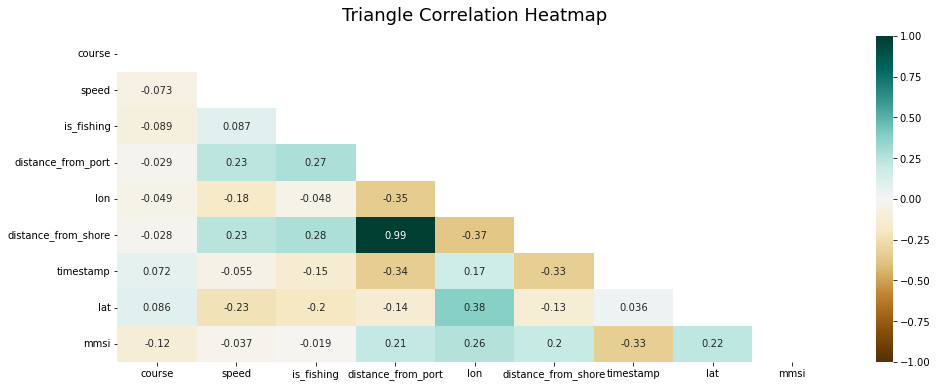

In [48]:
mlu.correlation_heatmap(df_basic)

Let's do a feature importance. Due to the fact we have the same feature in different time windows, I want to do the feature importancies only with one window at a time. 

Hints:
- I dont want to repeat features, so if there exists measure_feature vs feature, I'll take measure_feature.
- I want to drop features noisy to the model. These are: mmsi, timestamp, lat and lon. (maybe more?)
- Distance from port is a [0,1] feature. Should I drop it?
- Example: I want measure_speed and measure_speed_10800 also, but no speed!

##### Feature selection - Random Forest

In the following code, I will extract the features important from a random forest classifier model

In [46]:
# these columns have no impact on the models prediction
columns_to_drop_always = ['mmsi','is_fishing','lat','lon','timestamp','speed','course']

In [47]:
# dataframe of fixed_gear with the non important columns dropped + only one time window
cols = fexp.column_select(fixed_gear_df,True,['1800'])

In [48]:
X = fixed_gear_df[cols]
y = fixed_gear_df['is_fishing']

In [49]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

<BarContainer object of 19 artists>

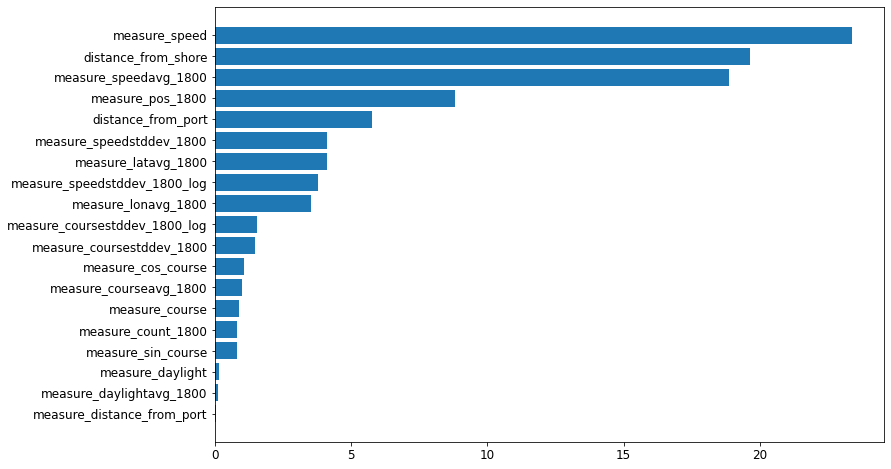

In [50]:
# showing the feature importances in a dataframe
mlu.feature_importances_rf(X_train, X_test, y_train, y_test)

##### Permutation importance

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test) # a fitted model must be given

In [ ]:
# ploting the results of permutation
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# Check if the high correlation between distance_from_port affected the results

In [ ]:
# Tengo que repetir el proceso con diferentes windows, y luego combinandolas entre ellas

In [ ]:
# Pruebo con todas las variables

In [ ]:
X_train, X_test, y_train, y_test = mlu.X_y_split(fixed_gear_df,0.2)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

feature_importances = {k:v*100 for k,v in zip(X_train.columns,rf.feature_importances_)}

feature_importances_df = pd.DataFrame(data=feature_importances.values(),index=feature_importances.keys(),columns=['percentage'])

In [ ]:
feature_importances_df.sort_values('percentage',ascending=False).head(10)

##### Logistic Regression

In [ ]:
# logistic regression for feature importance
from matplotlib import pyplot
# define the model
model = LogisticRegression()
# fit the model
model.fit(X_train, y_train)

In [ ]:
# get importance
importance = model.coef_[0]
importance

In [ ]:
feature_importances = {k:v*100 for k,v in zip(X_train.columns,importance)}
feature_importances

In [ ]:
feature_importances.keys()

In [ ]:
# plot feature importance
plt.figure(figsize=(20,10))
plt.barh(list(feature_importances.keys()),np.abs(list(feature_importances.values())))
pyplot.show()

##### Grid Search

In [ ]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
 
forest_reg = RandomForestClassifier()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
y_pred_train = grid_search.predict(X_train)

y_pred_test = grid_search.predict(X_test)

In [ ]:
mlu.metrics(y_test,y_train,y_pred_test,y_pred_train,'RF')

In [ ]:
# save the model with pickle

In [ ]:
# save the model to disk
pickle.dump(grid_search, open('grid_search.pkl', 'wb'))

In [51]:
# load the model from disk
pickled_model = pickle.load(open('grid_search.pkl', 'rb'))
pickled_model.predict(X_test)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- measure_count_10800
- measure_count_21600
- measure_count_3600
- measure_count_43200
- measure_count_86400
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 19 features, but RandomForestClassifier is expecting 74 features as input.

## Lets try simple models with the minimum dataset

In [49]:
fixed_gear_df.columns

Index(['measure_coursestddev_43200', 'measure_speedavg_86400',
       'measure_coursestddev_1800_log', 'measure_coursestddev_10800_log',
       'measure_courseavg_43200', 'measure_cos_course',
       'measure_daylightavg_1800', 'measure_coursestddev_21600',
       'measure_speedstddev_1800', 'measure_distance_from_port',
       'measure_count_1800', 'course', 'measure_sin_course',
       'measure_speedstddev_10800', 'measure_speedavg_21600', 'speed',
       'is_fishing', 'measure_pos_86400', 'measure_daylightavg_43200',
       'measure_latavg_86400', 'measure_latavg_10800', 'distance_from_port',
       'measure_latavg_1800', 'measure_pos_1800', 'measure_lonavg_3600',
       'measure_count_3600', 'lon', 'measure_speedavg_10800',
       'measure_latavg_3600', 'measure_coursestddev_43200_log',
       'measure_latavg_21600', 'measure_daylightavg_10800',
       'measure_count_86400', 'measure_count_21600',
       'measure_speedstddev_86400_log', 'measure_lonavg_1800',
       'measure_course

## Fixed gear

##### Creating the dataframe

In [50]:
min_cols = fexp.column_select(fixed_gear_df,True,col_groups=['1800','21600'])

In [51]:
min_df = fixed_gear_df[min_cols]
min_df.head(3)

,measure_cos_course,measure_sin_course,is_fishing,distance_from_port,measure_course,distance_from_shore,measure_daylight,measure_speed,measure_coursestddev_1800_log,measure_daylightavg_1800,...,measure_speedavg_21600,measure_latavg_21600,measure_count_21600,measure_coursestddev_21600_log,measure_lonavg_21600,measure_speedstddev_21600_log,measure_speedstddev_21600,measure_daylightavg_21600,measure_pos_21600,measure_courseavg_21600
0,-0.617249,0.344969,0,791420.3750,0.418889,534897.1250,1.0,0.505882,-2.999915,1.0,...,0.884034,55.420507,7.0,-0.334013,-16.236625,-0.806469,0.155146,1.0,0.033839,0.114048
1,-0.617249,0.344969,0,791420.3750,0.418889,534897.1250,1.0,0.505882,-2.999940,1.0,...,0.836765,55.407557,8.0,-0.250814,-16.225128,-0.715394,0.191578,1.0,0.041573,0.152153
2,-0.658356,0.258007,0,785714.8125,0.440556,540286.6875,1.0,0.505882,-1.334011,1.0,...,0.800000,55.392846,9.0,-0.212711,-16.212564,-0.678991,0.208416,1.0,0.050718,0.184198


##### Train test split

In [54]:
X_train, X_test, y_train, y_test = mlu.X_y_split(min_df,0.3)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92274, 29), (39546, 29), (92274,), (39546,))

##### Scaling the distance features

In [57]:
X_train['distance_from_port'], X_test['distance_from_port'] = mlu.min_max_scaler(X_train[['distance_from_port']], 
                                                                             X_test[['distance_from_port']])

In [58]:
X_train['distance_from_shore'], X_test['distance_from_shore'] = mlu.min_max_scaler(X_train[['distance_from_shore']], 
                                                                             X_test[['distance_from_shore']])

##### Feature Importances

<BarContainer object of 29 artists>

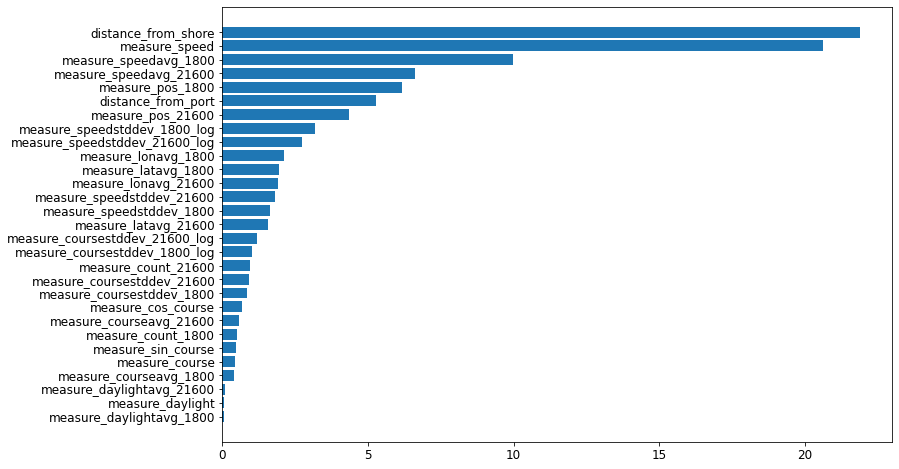

In [59]:
mlu.feature_importances_rf(X_train, X_test, y_train, y_test)

##### GridSearchCV

In [284]:
param_grid = {'n_estimators': [3, 10, 30], 
              'max_features': [2, 4, 6, 8], 
              'max_depth':[2,5,8,10]}
 
forest_reg = RandomForestClassifier()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='f1')

In [285]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 8, 10],
                         'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             scoring='f1')

In [286]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

y_pred_train = grid_search.predict(X_train)

y_pred_test = grid_search.predict(X_test)

mlu.metrics(y_test,y_train,y_pred_test,y_pred_train,'RF')

{'max_depth': 10, 'max_features': 8, 'n_estimators': 30}
RandomForestClassifier(max_depth=10, max_features=8, n_estimators=30)


,MAE,MSE,RMSE,R2,set,model
0,0.019695,0.019695,0.140340,0.911509,test,RF
1,0.011986,0.011986,0.109481,0.945945,train,RF


**OJO!** Me esta cogiendo los parametros mas altos que le he dejado escoger, entiendo que deberia probar valores mas altos para ver que onda, pero por capacidad computacional y viendo que me da buenos resultados, lo dejo así.

In [264]:
# Voy a probar metiendole otros datos

drifting_df_sample = drifting_df[min_cols].sample(30000)
X_test_2 = drifting_df_sample[min_cols].drop('is_fishing',axis=1)
y_test_2 = drifting_df_sample[min_cols].is_fishing

In [265]:
X_test_2['distance_from_port'] = minmax.transform(X_test_2[['distance_from_port']]) 
X_test_2['distance_from_shore'] = minmax.transform(X_test_2[['distance_from_shore']]) 

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- distance_from_port
Feature names seen at fit time, yet now missing:
- distance_from_shore

  warnings.warn(message, FutureWarning)


In [266]:
X_test_2.shape, y_test_2.shape

((30000, 40), (30000,))

In [267]:
y_pred_test = grid_search.predict(X_test_2)

mlu.metrics(y_test_2,y_train,y_pred_test,y_pred_train,'RF')

,MAE,MSE,RMSE,R2,set,model
0,0.184600,0.184600,0.429651,0.159855,test,RF
1,0.015684,0.015684,0.125237,0.929390,train,RF


Para otro tipo de datos no funciona tanto. Puede ser, si el nuevo tipo de barco pesca mas lejos de la costa o a diferentes speeds, el modelo lo clasifica mal.

Random Forest and Decision Trees seems to work well with this data because there are a few features with high impact on the model prediction.

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> El siguiente paso es crear una pipeline que me haga todo el proceso, para poderselo aplicar directamente a todo el resto de pesqueros.
</div>

In [163]:
# spliting data into train and test
# X_train, X_test, y_train, y_test = mlu.X_y_split(df,0.25)

# saving mmsi numbers
# mmsi_train, mmsi_test = X_train['mmsi'], X_test['mmsi']

**Crear una clase? Pensarlo**

## All vessels together

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> Tambien a hacer: Juntar todos los datos de todos los pesqueros y ver como predice mi modelo! Es interesante
</div>

In [15]:
dfs = [drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df]

In [16]:
df_all_gears = pd.concat([drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df], ignore_index=True)

In [17]:
cols = fexp.column_select(fixed_gear_df,True)
cols

['measure_cos_course',
 'measure_sin_course',
 'is_fishing',
 'distance_from_port',
 'measure_course',
 'distance_from_shore',
 'mmsi',
 'measure_daylight',
 'measure_speed']

In [18]:
df_all_gears.shape

(1997100, 81)

In [19]:
df_all_gears = df_all_gears[cols].dropna()
df_all_gears.shape

(1997028, 9)

In [20]:
# coger una sample
df_all_gears_s = df_all_gears.sample(500000,random_state=45)

In [ ]:
df_all_gears.to_csv('')

In [34]:
    # usando el mmsi train split hecho por mi

In [23]:
X = df_all_gears_s.drop('is_fishing',axis=1)
y = df_all_gears_s['is_fishing']

In [72]:
X_train, X_test, X_val, y_train, y_test, y_val = mlu.train_test_val_mmsi_split(X,y,0.6,0.1)

Train: 40.5% |          Test: 48.2% |          Validation: 11.3%


In [19]:
X_train, X_test, y_train, y_test = mlu.X_y_split(df_all_gears_s,0.25)

In [20]:
# saving mmsi numbers
mmsi_train, mmsi_test = X_train['mmsi'], X_test['mmsi']
X_train.drop('mmsi', inplace=True, axis=1)
X_test.drop('mmsi', inplace=True, axis=1)

In [23]:
X_train['distance_from_port'], X_test['distance_from_port'] = min_max_scaler(X_train[['distance_from_port']], 
                                                                             X_test[['distance_from_port']])

In [24]:
X_train['distance_from_shore'], X_test['distance_from_shore'] = min_max_scaler(X_train[['distance_from_shore']], 
                                                                             X_test[['distance_from_shore']])

In [177]:
# mlu.feature_importances_rf(X_train, X_test, y_train, y_test)

In [26]:
param_grid = {'n_estimators': [60,100,150], 
              'max_features': [3,4,5], 
              'max_depth':[8,10,12,15]}
 
forest_reg = RandomForestClassifier()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='f1')

In [179]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 10, 12, 15],
                         'max_features': [3, 4, 5],
                         'n_estimators': [60, 100, 150]},
             scoring='f1')

In [190]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

mlu.metrics(y_test,y_train,y_pred_test,y_pred_train,'RF')

{'max_depth': 15, 'max_features': 5, 'n_estimators': 150}
RandomForestClassifier(max_depth=15, max_features=5, n_estimators=150)


,Accuracy,Recall,F1,set,model
0,0.914016,0.921668,0.911223,test,RF
1,0.940256,0.945936,0.937709,train,RF


**Nota:** Habria que tunear mejor los parametros, pero lo hare cuando tenga tiempo, de momento vamos a ver que tal ha predecido. Subir los n_estimators

In [150]:
vamos_a_ver = pd.DataFrame({'y_normal':y_test, 'y_pred':y_pred_test})

In [181]:
confusion_matrix(y_test, y_pred_test)

array([[59092,  6060],
       [ 4688, 55160]], dtype=int64)

In [27]:
pickle.dump(grid_search, open('grid_search_depth_15.pkl', 'wb'))

In [37]:
pickled_model = pickle.load(open('grid_search_depth_15.pkl', 'rb'))

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> HACER ESTO PARA GUARDAR EL PICKLE!
</div>

In [ ]:
# RandomForestClassifier(grid_search.best_estimator_)

<div class="alert alert-danger" role="alert">
  <strong>Nota:</strong> Para ver graficamente mis predicciones, tengo que crear un codigo que me guarde el mmsi, para despues de hacer la prediccion poderlo añadir y plotear por barco
</div>

In [191]:
# Probar con otros datos que no haya visto el modelo

In [193]:
# Probar como predice el modelo un longline vs purse seine

Hay que hacer que esta funcion te haga un split de los datos, en training data y validation data. La funcion no debe devolver nada, y luego se cargaran los datos deseados que estaran en la carpeta de data

In [3]:

# all the data is here
path = 'data/training_data/' 

# all the gear types listed here
gear_type_list = ['Drifting_longlines', 'Fixed_gear','Purse_seines','Trawlers','Trollers','Pole_and_line','Unknown']

# loading all dataframes and concatenating into one
drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df = ld.load_multiple(gear_type_list)
dfs = [drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df]

# lets label the data creating a new column called 'gear_type'
for df,name in zip(dfs,gear_type_list):
    df['gear_type'] = name

df_all_gears = pd.concat([drifting_df, fixed_gear_df, purse_df, trawlers_df, trollers_df, pole_df, unknown_df], ignore_index=True)


In [11]:
# a partir de aqui empieza lo nuevo

train, val = mlu.mmsi_split(df_all_gears,0.8)

In [18]:
# guardo train y val en archivo csv
train_percentage = int(round(train.shape[0]/df_all_gears.shape[0]*100,0))
val_percentage = int(round(val.shape[0]/df_all_gears.shape[0]*100,0))

train.to_csv('data/train_by_mmsi.csv')
val.to_csv('data/validation_by_mmsi.csv')

print('\n'+f'Train split: {train_percentage}% | Validation split: {val_percentage}% ')

# tarda mucho, pensar si es mejor no guardarlo y utilizarlo directamente como return de la funcion en los .py